# Airline Data Analysis Using SparkML
Taido Purason, Aap Vare, Peep Kolberg, Martin Masaba

In [0]:
from pyspark.sql.types import IntegerType, FloatType, DateType
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors
from pyspark.ml.param import Param, Params
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from functools import reduce

In [0]:
SEED = 42
DISPLAY_LIMIT = 10

In [0]:
airline_df = spark.read.format("delta").load("dbfs:/user/airline/table")

In [0]:
airline_df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: string (nullable = true)
 |-- DEP_TIME: string (nullable = true)
 |-- DEP_DELAY: string (nullable = true)
 |-- TAXI_OUT: string (nullable = true)
 |-- WHEELS_OFF: string (nullable = true)
 |-- WHEELS_ON: string (nullable = true)
 |-- TAXI_IN: string (nullable = true)
 |-- CRS_ARR_TIME: string (nullable = true)
 |-- ARR_TIME: string (nullable = true)
 |-- ARR_DELAY: string (nullable = true)
 |-- CANCELLED: string (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: string (nullable = true)
 |-- CRS_ELAPSED_TIME: string (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: string (nullable = true)
 |-- AIR_TIME: string (nullable = true)
 |-- DISTANCE: string (nullable = true)
 |-- CARRIER_DELAY: string (nullable = true)
 |-- WEATHER_DELAY: strin

In [0]:
airline_df.count()

Out[77]: 43051239

In [0]:
# cast columns

def cast_types(airline_df):
     return airline_df.withColumn("FL_DATE", airline_df.FL_DATE.cast(DateType())) \
                   .withColumn("OP_CARRIER_FL_NUM", airline_df.OP_CARRIER_FL_NUM.cast(IntegerType())) \
                   .withColumn("CRS_DEP_TIME", airline_df.CRS_DEP_TIME.cast(IntegerType())) \
                   .withColumn("DEP_TIME", airline_df.DEP_TIME.cast(FloatType())) \
                   .withColumn("DEP_DELAY", airline_df.DEP_DELAY.cast(FloatType())) \
                   .withColumn("TAXI_OUT", airline_df.TAXI_OUT.cast(FloatType())) \
                   .withColumn("WHEELS_OFF", airline_df.WHEELS_OFF.cast(FloatType())) \
                   .withColumn("WHEELS_ON", airline_df.WHEELS_ON.cast(FloatType())) \
                   .withColumn("TAXI_IN", airline_df.TAXI_IN.cast(FloatType())) \
                   .withColumn("CRS_ARR_TIME", airline_df.CRS_ARR_TIME.cast(IntegerType())) \
                   .withColumn("ARR_TIME", airline_df.ARR_TIME.cast(FloatType())) \
                   .withColumn("ARR_DELAY", airline_df.ARR_DELAY.cast(FloatType())) \
                   .withColumn("CANCELLED", airline_df.CANCELLED.cast(FloatType())) \
                   .withColumn("DIVERTED", airline_df.DIVERTED.cast(FloatType())) \
                   .withColumn("CRS_ELAPSED_TIME", airline_df.CRS_ELAPSED_TIME.cast(FloatType())) \
                   .withColumn("ACTUAL_ELAPSED_TIME", airline_df.ACTUAL_ELAPSED_TIME.cast(FloatType())) \
                   .withColumn("AIR_TIME", airline_df.AIR_TIME.cast(FloatType())) \
                   .withColumn("DISTANCE", airline_df.DISTANCE.cast(FloatType())) \
                   .withColumn("CARRIER_DELAY", airline_df.CARRIER_DELAY.cast(FloatType())) \
                   .withColumn("WEATHER_DELAY", airline_df.WEATHER_DELAY.cast(FloatType())) \
                   .withColumn("NAS_DELAY", airline_df.NAS_DELAY.cast(FloatType())) \
                   .withColumn("SECURITY_DELAY", airline_df.SECURITY_DELAY.cast(FloatType())) \
                   .withColumn("LATE_AIRCRAFT_DELAY", airline_df.LATE_AIRCRAFT_DELAY.cast(FloatType()))
    
airline_df = cast_types(airline_df)

In [0]:
print("Count before preprocessing", airline_df.count())

Count before preprocessing 43051239


We remove the following columns:
"CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY", "CANCELLATION_CODE", "AIR_TIME", "ACTUAL_ELAPSED_TIME", "ARR_DELAY", "ARR_TIME", "TAXI_IN", "WHEELS_ON", "WHEELS_OFF", "TAXI_OUT", "DEP_DELAY", "DEP_TIME", "DIVERTED"

The reason being that they either have too many null values and/or they would just give away if the flight is cancelled or not, making the prediction with ML models pointless.

For example "ACTUAL_ELAPSED_TIME", "ARR_DELAY", "ARR_TIME", "TAXI_IN", "WHEELS_ON", "WHEELS_OFF", "TAXI_OUT", "DEP_DELAY", "DEP_TIME" are not present for any cancelled flights and are only nulls for a handful (10,000-100,000) of non-cancelled columns, making it very easy to predict wether flight was cancelled without any models.

In a real-world task, it would make sense to predict which flight was going to be cancelled before the actual flight, so we also remove those columns (many of which are removed anyway due to reasons above). For example, "DIVERTED" would not be available before the flight and also, it is not available for any cancelled flights, so we ignore it.

We are left with columns 'FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE' (and 'CANCELLED').

Since there are only 38 rows with nulls left, we won't bother imputing them and drop them, since they would have almost no effect on the result, considering the size of the dataset.

In [0]:
remove_cols = ["CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY", "CANCELLATION_CODE", "AIR_TIME", "ACTUAL_ELAPSED_TIME", "ARR_DELAY", "ARR_TIME", "TAXI_IN", "WHEELS_ON", "WHEELS_OFF", "TAXI_OUT", "DEP_DELAY", "DEP_TIME", "DIVERTED"]

def preprocessing(df):
    df = df.drop(*remove_cols)
    return df.filter(reduce(lambda a, b: a & F.col(b).isNotNull(), df.columns, F.lit(True)))


In [0]:
airline_df = preprocessing(airline_df)
print("Count after preprocessing", airline_df.count())

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
<command-789236164028240> in <module>
      1 airline_df = preprocessing(airline_df)
----> 2 print("Count after preprocessing", airline_df.count())

/databricks/spark/python/pyspark/sql/dataframe.py in count(self)
    686         2
    687         """
--> 688         return int(self._jdf.count())
    689 
    690     def collect(self):

/databricks/spark/python/lib/py4j-0.10.9.1-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1302 
   1303         answer = self.gateway_client.send_command(command)
-> 1304         return_value = get_return_value(
   1305             answer, self.gateway_client, self.target_id, self.name)
   1306 

/databricks/spark/python/pyspark/sql/utils.py in deco(*a, **kw)
    115     def deco(*a, **kw):
    116         try:
--> 117             return f(*a, **kw)
    118         except py4j.protocol.Py4JJava

In [0]:
display(airline_df)

FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,CRS_ARR_TIME,CANCELLED,CRS_ELAPSED_TIME,DISTANCE
2014-01-01,AA,2377,ICT,DFW,1135,1300,0.0,85.0,328.0
2014-01-01,AA,2378,MIA,TPA,2225,2325,0.0,60.0,204.0
2014-01-01,EV,2500,DFW,HOU,2105,2205,1.0,60.0,247.0
2014-01-01,EV,2502,CRW,DFW,1655,1900,0.0,185.0,946.0
2014-01-01,EV,2502,DFW,CRW,1320,1625,0.0,125.0,946.0
2014-01-01,EV,2503,AMA,DFW,1925,2030,0.0,65.0,312.0
2014-01-01,EV,2503,DFW,AMA,1740,1850,0.0,70.0,312.0
2014-01-01,EV,2504,DFW,SHV,2040,2130,0.0,50.0,190.0
2014-01-01,EV,2505,AMA,DFW,1705,1810,0.0,65.0,312.0
2014-01-01,EV,2505,DFW,AMA,1520,1630,0.0,70.0,312.0


### Feature engineering
We create additional features from the date column.

In [0]:
def feature_engineering(df):
    return (df
            .withColumn("FL_YEAR", F.year(F.col("FL_DATE")) - 2009)
            .withColumn("FL_MONTH", F.month(F.col("FL_DATE")))
            .withColumn("FL_DAYOFMONTH", F.dayofmonth(F.col("FL_DATE")))
            .withColumn("FL_DAYOFWEEK", F.dayofweek(F.col("FL_DATE")))
           )
    
airline_df = feature_engineering(airline_df)

Some columns are numeric and can be fed to models as is (they could also be binned and converted to onehot).

In [0]:
# added only some for now until it is figured out how to handle nulls
numeric_features = ["OP_CARRIER_FL_NUM", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE"]

categorical_features = ["ORIGIN", "DEST", "OP_CARRIER"]

# month, dayofmonth and dayofweek could be numeric or categorical
date_columns = ["FL_MONTH", "FL_DAYOFMONTH", "FL_DAYOFWEEK"]
numeric_features += date_columns # adding date features to numeric

airline_df = airline_df.withColumnRenamed("CANCELLED", "label")

In [0]:
indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_INDEXED", handleInvalid="error")
    for col in categorical_features
]

encoders = [
    OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[f"{indexer.getOutputCol()}_ENCODED"], handleInvalid="error")
    for indexer in indexers
]

assembler = VectorAssembler(inputCols=[encoder.getOutputCols()[0] for encoder in encoders] + numeric_features, outputCol="features")

stages = indexers + encoders + [assembler]

In [0]:
# it makes sense to split the data before fitting the pipeline
# the other scenario would not be a good ML practice

(train_df, test_df) = airline_df.randomSplit([0.7, 0.3], seed=SEED)

In [0]:
pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(train_df)

In [0]:
train_df = pipeline_model.transform(train_df).select("features", "label").cache()

In [0]:
models = {
    "logistic_regression": LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.1),
    "decision_tree": DecisionTreeClassifier(labelCol="label", featuresCol="features"),
    "random_forest": RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=5),
    "gradient_boosting": GBTClassifier(labelCol="label", featuresCol="features", maxIter=3, maxDepth=3, maxBins=16)
}

In [0]:
import time

trained_models = {}
for name, model in models.items():
    t_start = time.perf_counter()
    trained_model = model.fit(train_df)
    trained_models[name] = trained_model
    print(f"Training {name} took {time.perf_counter() - t_start}s\n")

Training logistic_regression took 611.0030860469997s

Training decision_tree took 3283.0432659069993s

Training random_forest took 3186.4508956220016s

Training gradient_boosting took 8319.269459869s



In [0]:
test_df = pipeline_model.transform(test_df).select("features", "label").cache()

In [0]:
scores = {}

for name, model in trained_models.items():    
    t_start = time.perf_counter()
    predictions =  model.transform(test_df)
    
    auc_evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")
    auc = auc_evaluator.evaluate(predictions)
    acc = predictions.filter(F.col("label") == F.col("prediction")).count() / predictions.count()
    print(f"Evaluating {name} on test set took {time.perf_counter() - t_start}s")

    scores[name] = {
        "acc": acc,
        "auc": auc
    }

Evaluating logistic_regression on test set took 835.0945459729992s
Evaluating decision_tree on test set took 51.541678897003294s
Evaluating random_forest on test set took 64.88337972099544s
Evaluating gradient_boosting on test set took 69.1587483809999s


In [0]:
results_df = spark.createDataFrame(data=[(k, v["auc"], v["acc"]) for k, v in scores.items()], schema = ["model", "auc", "accuracy"])
display(results_df)

model,auc,accuracy
logistic_regression,0.7059027976046222,0.983594207329563
decision_tree,0.5,0.983594207329563
random_forest,0.5,0.983594207329563
gradient_boosting,0.6754536633196849,0.983594207329563


Due to large class imbalance, looking at accuracy as instructed in the task instructions is quite useless, so we also display the AUC scores as well.

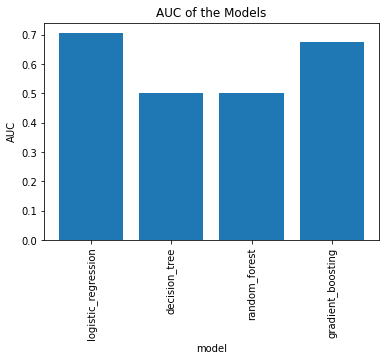

In [0]:
from matplotlib import pyplot as plt

x, y = zip(*[(k, v["auc"]) for k, v in scores.items()])
plt.bar(x, y)
plt.xlabel("model")
plt.ylabel("AUC")
plt.title("AUC of the Models")
plt.xticks(rotation=90)
plt.show()

AUC of 0.5 indicates that decision tree and random forest are no better than random guessing.

The best performing models

One possible reason of the low perfomance could be large dimensionality of the features that arise from creating one-hot vectors from the airline code. Also the large dataset means that it is not feasible to train better perfoming models (train for more iterations, use more trees).

Furthermore, it might be beneficial to undersample the large dataset.